In [209]:
import numpy as np
from scipy.optimize import minimize, LinearConstraint
import sklearn.datasets as datasets
import graphlearning as gl
import matplotlib.pyplot as plt
import time

In [187]:
"""
Returns the ith vector of the usual basis of R^k
Index starts at 0
Note: When idx is a (n, ) array (of indices), then it returns
an (n, k) array whose j-th row is the idx[j]-th vector of the
basis of R^k

### Example
# print(euclidean_basis(0, 5))
# print(euclidean_basis(2, 5))
# print(euclidean_basis([0, 2], 5))
"""

def euclidean_basis(idx, k):
    eye = np.eye(k)
    return eye[idx]



def vectorized_jacobian(u_flattened, W, idx, y, p):
    n = W.shape[0]
    k = u_flattened.size//n
    m = y.shape[0]    
    
    u = u_flattened.reshape((n,k))
    gradu = graph_grad(u)
    normed_gradu = np.apply_along_axis(np.linalg.norm, 2, gradu)
    y_bar = y.sum(axis = 0)/m
    
    if p > 2:
        # ... = w*normed_gradu**(p-2)
        a1 = W * (normed_gradu**(p-2)) + np.zeros((k, n, n)) # a1[s,i,r] = ...[i, r]
        A = np.transpose(a1, (1, 2, 0)) # A[i,r, s] = ...[i, r]

        u1 = np.zeros( (n, n, k) ) + u #u1[i, r, s] = u[r, s]

        u21 = np.zeros( (n,n,k) ) + u # u21[r, i, s] = u[i, s]
        u2 = np.swapaxes(u21, 0, 1) # u2[i, r, s] = u[i, s]

        C = u1 - u2

        B = np.zeros( (n, k) )
        B[idx] = y - y_bar

        jac = (A * C).sum(axis = 0) - B
    
    elif p == 2:
        a1 = W + np.zeros((k, n, n)) # a1[s,i,r] = W[i, r]
        A = np.transpose(a1, (1, 2, 0)) # A[i, r, s] = W[i, r]
        
        u1 = np.zeros( (n, n, k) ) + u #u1[i, r, s] = u[r, s]

        u21 = np.zeros( (n,n,k) ) + u # u2[r, i, s] = u[i, s]
        u2 = np.swapaxes(u21, 0, 1)

        C = u1 - u2

        B = np.zeros( (n, k) )
        B[idx] = y - y_bar
            
        jac = (A * C).sum(axis = 0) - B
    
    return jac.flatten()

def penergy(u_flattened, W, idx, y, p):
    k = y.shape[1]
    n = int(u_flattened.size/k)
    u = u_flattened.reshape((n,k))
    gradu = graph_grad(u)
    y_bar = (1/y.shape[0]) * y.sum(axis = 0)
    
    first_summand = (1/(2*p)) * (W * (np.apply_along_axis(np.linalg.norm, 2, gradu) ** p)).sum()
    second_summand = np.sum( (y - y_bar) * u[idx] )

    return first_summand - second_summand

def graph_grad(u):
    gradu = -u[:, np.newaxis] + u
    return gradu

def degrees(W):
    return np.ravel((W.sum(axis = 1)))

def predict(u):
    return np.argmax(u, axis = 1)
    

# Solves the p-poisson equation on a graph with weight matrix W
# and labels y on the elements with indices idx
# using gradient descent
def gradient_ppoisson(W, idx, y, p, start = np.zeros(1)):
    d = degrees(W)
    n = W.shape[0]
    k = y.shape[1]
    eye = np.eye(k)

    labels = predict(y)

    if not start.all():
        model = gl.ssl.poisson(W, solver='gradient_descent')
        start = model.fit(idx, labels).flatten()
    
    constrain_matrix = np.concatenate([d[i] * eye for i in range(n)], axis = 1)
    linear_constraint = LinearConstraint(constrain_matrix, np.zeros(k), np.zeros(k))
    
    res = minimize(penergy, x0 = start, args = (W, idx, y, p), jac = vectorized_jacobian, method = 'trust-constr', constraints = linear_constraint)
    
    u = res.x.reshape(n,k)
    
    return u

class ppoisson():
    def __init__(W):
        self.W = W
        self.sol = None
        
    def fit(self, train_ind, train_labels, p, start = np.zeros(1)):
        d = degrees(W)
        n = W.shape[0]
        k = y.shape[1]
        eye = np.eye(k)

        labels = predict(y)

        if not start.all():
            model = gl.ssl.poisson(W, solver='gradient_descent')
            start = model.fit(idx, labels).flatten()

        constrain_matrix = np.concatenate([d[i] * eye for i in range(n)], axis = 1)
        linear_constraint = LinearConstraint(constrain_matrix, np.zeros(k), np.zeros(k))

        res = minimize(penergy, x0 = start, args = (W, idx, y, p), jac = vectorized_jacobian, method = 'trust-constr', constraints = linear_constraint)

        u = res.x.reshape(n,k)

        self.sol = u
        
        return u
    

In [188]:
sample_size = 200
X,labels = gl.datasets.load('mnist')
X = X[:sample_size]
labels = labels[:sample_size]

W = gl.weightmatrix.knn(X,10).toarray()
train_ind = gl.trainsets.generate(labels, rate=3)
train_labels = labels[train_ind]

In [207]:
model = gl.ssl.poisson(W, solver='gradient_descent')
u = model.fit(train_ind, train_labels)
pred_labels = model.predict()

p = 2
euclidean_labels = euclidean_basis(train_labels, 10)
my_u = gradient_ppoisson(W, train_ind, euclidean_labels, p)
my_pred_labels = predict(my_u)

print("Energy of GraphLearning Solution: %.3f"%penergy(u.flatten(), W, train_ind, euclidean_labels, p))
print("Energy of custom solution: %.3f"%penergy(my_u.flatten(), W, train_ind, euclidean_labels, p))
print("Accuracy of custom solution: %.2f%%"%gl.ssl.ssl_accuracy(my_pred_labels, labels, len(train_ind)))
print("Accuracy of GraphLearn solution: %.2f%%"%gl.ssl.ssl_accuracy(pred_labels, labels, len(train_ind)))
print("Number of different predictions: ", np.count_nonzero(my_pred_labels - pred_labels))

Energy of GraphLearning Solution:-89.574
Energy of custom solution:-91.403
Accuracy of custom solution: 71.76%
Accuracy of GraphLearn solution:72.94%
Number of different predictions 7


In [ ]:
p_vals = [[2, 4], [8, 16], [32, 64]] + [[100 + 10 * i, 105 + 10 * i]  for i in range(0,10)] + [[200 + 2*i, 201 + 2*i] for i in range(0, 100)]
k = 10

model = gl.ssl.poisson(W, solver='gradient_descent')
u = model.fit(train_ind, train_labels)
pred_labels = predict(u)

euclidean_train_labels = euclidean_basis(train_labels, k)

# Run and plot for varying p
for i in range(len(p_vals)):
    for j in range(len(p_vals[i])):
        start_time = time.time()

        p = p_vals[i][j]

        my_u = gradient_ppoisson(W, train_ind, euclidean_train_labels, p, start = my_u.flatten())
        my_pred_labels = predict(my_u)

        discrepancies = np.count_nonzero(my_pred_labels - pred_labels)
        accuracy = gl.ssl.ssl_accuracy(my_pred_labels, labels, len(train_ind))
        energy = np.around(penergy(my_u.flatten(), W, train_ind, euclidean_train_labels, p), 2)
        end_time = time.time()
        minutes = (end_time - start_time)/60
        
        info_str = f"########### Gradient Descent (w/ Jacobian) for p = {p}\n"\
                        f"Energy = {energy:.2f}\n"\
                        f"Discrepancies = {discrepancies}"\
                        f"\nAccuracy = {accuracy:.2f}%\n"\
                        f"Runtime = {minutes:.2f} min"

        print(info_str)
        

########### Gradient Descent (w/ Jacobian) for p = 2
Energy = -91.40
Discrepancies = 7
Accuracy = 71.76%
Runtime = 0.02 min
########### Gradient Descent (w/ Jacobian) for p = 4
Energy = -51.36
Discrepancies = 18
Accuracy = 71.76%
Runtime = 3.18 min
########### Gradient Descent (w/ Jacobian) for p = 8
Energy = -43.03
Discrepancies = 36
Accuracy = 68.82%
Runtime = 10.22 min


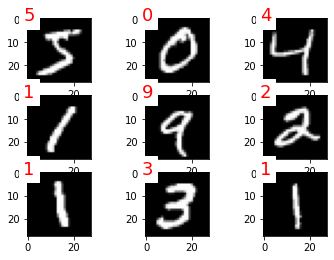

In [75]:
for i in range(9):  
    plt.subplot(3, 3, i + 1)
    plt.imshow(X[i].reshape(28,28).T, cmap=plt.get_cmap('gray'))
    plt.text(0.5, 0.5, str(pred_labels[i]), fontsize=18, ha='center', color = 'red', backgroundcolor = 'white')